In [1]:
%matplotlib inline

import sys, os
import itertools
import collections
import pickle
import time
import datetime

import tensorflow as tf
import numpy as np

import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler
import scipy
from scipy import optimize

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

In [2]:
from thurner_model import NoiseTrader, Fund, DynamicFund, find_equilibrium 
import plotting

In [3]:
class Env:
    """
    Docstring
    """
    # Define our fundamental value V and asset-supply N
    V = 1.
    N = 1000.
    
    initial_price = 1.
    
    # Define noise trader (NoiseTrader Class defined in thurner_model.py)
    roh_nt = 0.99
    sigma_nt = 0.035
    noise_trader = NoiseTrader(roh_nt, sigma_nt, V, N)
    initial_nt_spending = V*N
    
    def __init__(self):
        # tracks trader spending
        
        self.p_t = self.initial_price
        self.xi_t = self.initial_nt_spending
        self.done = False 
        
    # when resetting the environment, we set the state back to the initial one 
    def reset(self):
        self.p_t = self.initial_price
        self.xi_t = self.initial_nt_spending

    def step(self, funds):
        """Finds equilibrium, and updates environment parameters""" 
        # track the old price for the investor mechanism
        p_tm1 = self.p_t
        
        # 1. Find the new price for the timestep
        self.xi_t = self.noise_trader.cash_spending(self.xi_t)
        self.p_t = find_equilibrium(self.xi_t, funds)
    
        # 2. update the holdings of all the funds (wealth, shares and cash)
        current_wealth = []
        current_return = [] 
        for fund in funds:
            fund.update_holdings(self.p_t)
            fund.check_and_make_bankrupt(self.p_t)
            
            fund.process_inflows(p_tm1, self.p_t)
            
            new_wealth_of_fund = fund.get_wealth(self.p_t)
            current_wealth.append(new_wealth_of_fund)
            current_return.append(fund.ret) 
            # set done to True if one fund increases its wealth 50-fold
            if new_wealth_of_fund > 50*fund.initial_wealth:
                self.done = True
                
        return current_wealth, current_return


# In[5]:

env = Env()


# In[6]:

# Create examples for observations to train the featurizer
tracked_fund = DynamicFund(25)
other_funds = [DynamicFund((i+1)*5) for i in range(9)]
other_funds.append(tracked_fund)
#print([f.beta for f in other_funds])

states = np.zeros((10000,2))
for i in range(10000):
    current_wealth,_ = env.step(other_funds)
    states[i] = np.array([env.p_t,
                          tracked_fund.get_wealth(env.p_t)
                         ])
    # record the state of the fund


# In[7]:


# (By Denny Britz)
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this

observation_examples = states 
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurized represenation.
# We use RBF kernels with different variances to cover different parts
# of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
print(featurizer.fit(scaler.transform(observation_examples)))


# In[8]:


def featurize_state(state):
    """
    Returns the featurized representation for a state.
    """
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]


# In[9]:


class LearningFund(DynamicFund):
    """
    Description: Base Class is DynamicFund, defined in thurner_model.py
    The Learning Fund learns its demand function via reinforcement learning
    """
    
    def __init__(self):
        # The learning fund does not need a beta
        
        self.cash = self.initial_wealth
        self.shares = 0 
        self.activation_delay = 0
        
        self.performance = 0.0
        self.previous_wealth = self.initial_wealth
        self.previous_investment = 0.0
   
    def get_state(self, p_t):
        # The state is composed of the current price, as well as the current
        # holdings of the fund
        state = np.array([p_t,
                          self.get_wealth(p_t)])
        return state

    def get_demand(self, p_t):
        """
        Args:
            p_t : current_price in the environment
        Returns:
            A number for the learning_fund's demand, estimated by the
            policy_estimator, based on the current state
        """ 
        if self.is_active():

            state = self.get_state(p_t)
            
            demand = policy_estimator.predict(state)
            
            max_demand = self.lambda_max * self.get_wealth(p_t) / p_t 

            return min(demand, np.array(max_demand))
        
        else:
            return np.array([0.]) 

# In[10]:


class PolicyEstimator():
    """
    Policy Function approximator. Also called Actor.
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just linear classifier
            self.mu = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            
            self.mu = tf.squeeze(self.mu)
            
            self.sigma = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            
            self.sigma = tf.squeeze(self.sigma)
            self.sigma = tf.nn.softplus(self.sigma) + 1e-5
            self.normal_dist = tf.contrib.distributions.Normal(self.mu,
                                                               self.sigma)
            sampled_demand = self.normal_dist._sample_n(1)
            upper_clip = np.float64(1000)
            lower_clip = np.float64(0)
            self.demand = tf.clip_by_value(sampled_demand, lower_clip, upper_clip) 

            # Loss and train op
            self.loss = -self.normal_dist.log_prob(self.demand) * self.target
            # Add cross entropy cost to encourage exploration (from A3C paper)
            self.loss -= 1e-1 * self.normal_dist.entropy()
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.train.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.demand, { self.state: state })

    def update(self, state, target, demand, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state,
                      self.target: target,
                      self.demand: demand  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss


# In[11]:


class ValueEstimator():
    """
    Value Function approximator. Also called Critic.
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just a linear classifier
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.train.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss


# In[12]:


def actor_critic(env, policy_estimator, value_estimator, num_episodes,
    num_timesteps=5000, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: My self created environment, specified above.
        policy_estimator: Policy Function to be optimized 
        value_estimator: Value function approximator, used as a critic
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and
        episode_rewards.
    """
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action",
                                                       "reward", "next_state",
                                                       "done"])
    
    funds_wealth_all_episodes = []
    funds_return_all_ep = []    
    learning_fund_stats = np.zeros((num_episodes, num_timesteps, 6))
    
    for i_episode in range(num_episodes):
        
        # Reset everything
        prices = []
        funds_wealth = []
        funds_returns = []
        # Create our learning_fund
        learning_fund = LearningFund()
        
        # Create the funds 
        number_of_funds = 10
        funds = [DynamicFund((i+1)*5) for i in range(number_of_funds)]
        
        # Add our learning fund
        funds.append(learning_fund)

        # Reset the environment 
        env.reset() 
        
        episode = []
        
        # One step in the environment
        for t in range(num_timesteps):
            
            # get the demand of the learning fund
            # (via getting demand from policy_estimator)
            
            demand = learning_fund.get_demand(env.p_t) 
            
            state = learning_fund.get_state(env.p_t)
            
            # Simulate a step in the environment,
            # record the wealth of all funds in current_wealth
            current_wealth, current_returns = env.step(funds)
            
            # record the wealth of all funds and the current price
            funds_wealth.append(current_wealth)
            funds_returns.append(current_returns)
            prices.append(env.p_t)
            
            # only update learning if learning fund is not bankrupt
            if learning_fund.is_active():
                # we assume one learning fund for the moment
                next_state = learning_fund.get_state(env.p_t) 
                
                reward = learning_fund.ret

                # experiment: high negative reward if learning_fund goes bankrupt
                #if learning_fund.activation_delay == 100:            
                #   reward = -100
 
                # Keep track of the transition
                episode.append(Transition(state=state, action=demand,
                                          reward=reward, next_state=next_state,
                                          done=env.done))
                
                # Update statistics
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] = t
                
                # Calculate TD Target
#                value_next = value_estimator.predict(next_state)
#                td_target = reward + discount_factor * value_next
#                td_error = td_target - value_estimator.predict(state)
#                
#                # Update the value estimator
#                value_estimator.update(state, td_target)
#                
#                # Update the policy estimator
#                # using the td error as our advantage estimate
#                policy_estimator.update(state, td_error, demand)
            
            learning_fund_stats[i_episode][t] = np.array([env.p_t,
                                                          demand,
                                                          learning_fund.get_wealth(env.p_t),
                                                          learning_fund.cash,
                                                          learning_fund.shares,
                                                          learning_fund.ret])
            
            # Print out which step we're on, useful for debugging.
            print("\rt: {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes,
                    stats.episode_rewards[i_episode - 1]), end="")

            
            state = next_state

        # After each episode, record the wealth of all funds
        funds_wealth_all_episodes.append(funds_wealth)
        funds_return_all_ep.append(funds_returns) 
        
        # Save the variables to disk.
        #checkpoint = "./checkpoints/{}-ep{}".format(experiment_name,i_episode)
        #save_path = saver.save(sess,checkpoint)         
        #print("\nModel saved in path: {}\n".format(save_path))
    
    return stats, funds_wealth_all_episodes, funds_return_all_ep, learning_fund_stats


FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)


## Load model from checkpoint 

In [4]:
#look at saved checkpoints
tf.train.get_checkpoint_state("./checkpoints/")

model_checkpoint_path: "./checkpoints/learn_longer-ep99"
all_model_checkpoint_paths: "./checkpoints/learn_longer-ep99"

In [ ]:
# specify which checkpoint to load
experiment_name = "learn_longer-ep99"

num_episodes = 1

start_time = time.time()

# Create the environment
env = Env()

# first initialization of our learning fund
learning_fund = LearningFund()

policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()

saver = tf.train.Saver(max_to_keep=1)

#policy_estimator = PolicyEstimator()
#value_estimator = ValueEstimator()

checkpoint = "./checkpoints/{}".format(experiment_name)

experiment_name += "_continued"

with tf.Session() as sess:
    
    saver.restore(sess, checkpoint)
    stats, funds_wealth_all_episodes, funds_return_all_ep, learning_fund_stats = actor_critic(env, policy_estimator, value_estimator,
                                                                      num_episodes=num_episodes, discount_factor=0.95)
    
print("\nDuration: {} min".format((time.time() - start_time)/60))

INFO:tensorflow:Restoring parameters from ./checkpoints/learn_longer-ep99
t: 786 @ Episode 1/1 (3.312840223312378))

In [47]:
#len(funds_wealth_all_episodes)

# Plotting

In [9]:
sns.set_style("darkgrid")

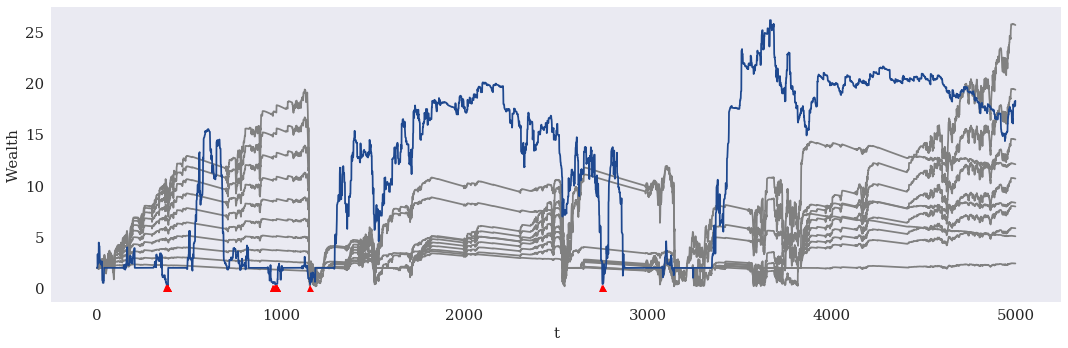

In [18]:
# wealth    
fig, ax = plt.subplots(figsize=(15,5))

episode = np.array(funds_wealth_all_episodes[0])

for j in range(11):

        # plot the learning fund blue
        if j == 10:
            ax.plot(episode.T[j], color=sns.xkcd_rgb["cobalt"])
        else:
            ax.plot(episode.T[j], color='gray')

learning_fund_wealth = np.array(funds_wealth_all_episodes[0]).T[-1]

markers_on = [i for i in range(len(learning_fund_wealth)) if learning_fund_wealth[i] <= 0.5]

ax.plot(np.linspace(0,0,5000), 'r^',
    markersize=7, markevery=markers_on)

ax.set_xlabel("t")
ax.set_ylabel("Wealth")

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
    item.set_fontname('serif')

    fig.tight_layout()
sns.despine()

timestr = time.strftime("%Y%m%d-%H%M%S")
filename = timestr + "_wealth"
#fig.savefig("./figures/paper/%s.png" % filename)

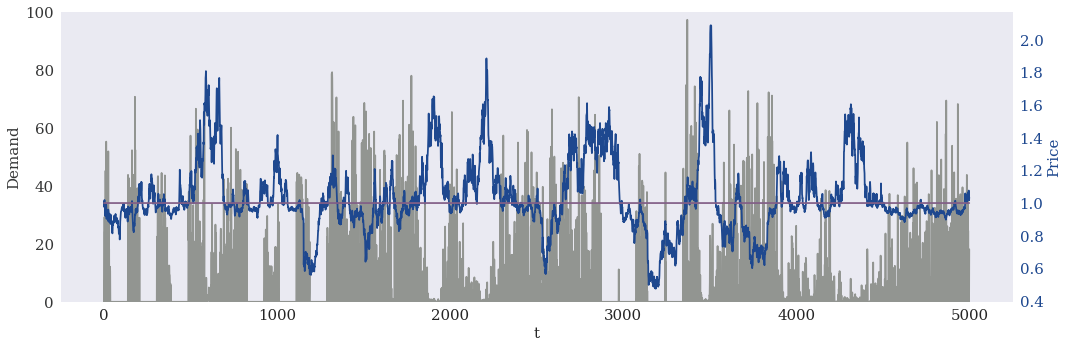

In [16]:
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.set_ylim([0,100])

episode = learning_fund_stats[0]

price = episode.T[0]
demand = episode.T[1] 
wealth = episode.T[2]
cash = episode.T[3]


ax1.plot(demand, color=sns.xkcd_rgb["grey"])


# plot wealth
#ax.plot(wealth, color=sns.xkcd_rgb['crimson'])

# mark defaults in red triangles 
#markers_on = [i for i in range(len(wealth)) if wealth[i] < 0.5]
#ax.plot(np.linspace(0,0,5000), 'b^',
#        markersize=15, markevery=markers_on)

ax1.set_xlabel("t")
ax1.set_ylabel("Demand", color=sns.xkcd_rgb["dark grey"])
ax1.tick_params('y', colors=sns.xkcd_rgb["dark grey"])

#plot price on different axis
ax2 = ax1.twinx()
ax2.plot(price, color=sns.xkcd_rgb["cobalt"])
ax2.set_ylabel('Price', color=sns.xkcd_rgb["cobalt"])
ax2.tick_params('y', colors=sns.xkcd_rgb["cobalt"])

# mark fundamental value
ax2.plot(np.linspace(1,1,5000), color=sns.xkcd_rgb["dusty purple"])

for ax in [ax1,ax2]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)
        item.set_fontname('serif')

fig.tight_layout()
timestr = time.strftime("%Y%m%d-%H%M%S")
filename = timestr + "_demand"
#fig.savefig("./figures/paper/%s.png" % filename)

In [ ]:
#TODO: Also look at returns

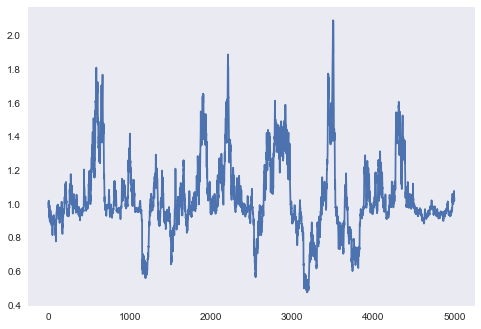

In [4]:
# price
plt.plot(learning_fund_stats[0].T[0])
sns.despine()

# Save and restor data

In [145]:
#path = "./past_data/simulations/"
#filename = "{}{}_data".format(path, experiment_name)
#
#with open(filename, 'wb') as f:
#    pickle.dump([stats.episode_rewards, funds_wealth_all_episodes,funds_return_all_ep, learning_fund_stats], f)
#
#    
#print("\nSaved as %s" %filename)


Saved as ./past_data/simulations/learn_longer-ep99_continued_data


In [3]:
filename = "past_data/simulations/learn_longer-ep99_continued_data" 

# Getting back the objects:
with open(filename, 'rb') as f:
    stats, funds_wealth_all_episodes, funds_returns, learning_fund_stats = pickle.load(f)

In [8]:
price = learning_fund_stats[0].T[0]
learning_fund_wealth = np.array(funds_wealth_all_episodes[0]).T[-1]
highlev_fund_wealth = np.array(funds_wealth_all_episodes[0]).T[-2]
lowlev_fund_wealth = np.array(funds_wealth_all_episodes[0]).T[0]

print(np.corrcoef(price, learning_fund_wealth))
print(np.corrcoef(price, highlev_fund_wealth))
print(np.corrcoef(price, lowlev_fund_wealth))

[[ 1.          0.21583929]
 [ 0.21583929  1.        ]]
[[ 1.          0.09560112]
 [ 0.09560112  1.        ]]
[[ 1.          0.09600612]
 [ 0.09600612  1.        ]]
